In [2]:
import numpy as np
import pandas as pd
import re
import torch
import random
from random import shuffle
import torch.nn as nn
import transformers
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertConfig, BertForSequenceClassification, BertTokenizer
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

# mps for mac, use GPU or cpu
device = torch.device("mps")    

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
import warnings
warnings.filterwarnings("ignore")

In [30]:
df=pd.read_csv('train.csv')

In [31]:
df.head()

,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival


In [32]:
df['category'].value_counts()

category
card_payment_fee_charged                            187
direct_debit_payment_not_recognised                 182
balance_not_updated_after_cheque_or_cash_deposit    181
wrong_amount_of_cash_received                       180
cash_withdrawal_charge                              177
                                                   ... 
lost_or_stolen_card                                  82
card_swallowed                                       61
card_acceptance                                      59
virtual_card_not_working                             41
contactless_not_working                              35
Name: count, Length: 77, dtype: int64

Selected only 12 classes

In [33]:
selected_classes = [
    "card_arrival", "card_linking", "pending_cash_withdrawal", 
    "card_delivery_estimate", "card_not_working", "lost_or_stolen_card", 
    "cancel_transfer", "wrong_amount_of_cash_received", "card_payment_fee_charged", 
    "transfer_not_received_by_recipient", "getting_virtual_card", "activate_my_card"
]

In [40]:
df_filtered = df[df['category'].isin(selected_classes)]
df_filtered['category'].value_counts()

category
card_payment_fee_charged              187
wrong_amount_of_cash_received         180
transfer_not_received_by_recipient    171
activate_my_card                      159
cancel_transfer                       157
card_arrival                          153
pending_cash_withdrawal               143
card_linking                          139
card_delivery_estimate                112
card_not_working                      112
getting_virtual_card                   98
lost_or_stolen_card                    82
Name: count, dtype: int64

In [ ]:
df_filtered.to_csv("banking77_reduced.csv", index=False)

AttributeError: 'DataFrameGroupBy' object has no attribute 'to_csv'

TRAINING

In [3]:
df_indoeng=pd.read_csv('banking77_indoeng.csv')


In [ ]:
df_indoeng.head()

,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival


In [18]:
def preprocess_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.strip()  # Remove leading/trailing spaces
    return text

# Apply preprocessing to the text column
df_indoeng['text'] = df_indoeng['text'].apply(preprocess_text)

In [19]:
df_indoeng.head()

,text,category
0,i am still waiting on my card,card_arrival
1,what can i do if my card still hasnt arrived a...,card_arrival
2,i have been waiting over a week is the card st...,card_arrival
3,can i track my card while it is in the process...,card_arrival
4,how do i know if i will get my card or if it i...,card_arrival


In [20]:
df_indoeng['category'].value_counts()

category
card_payment_fee_charged              460
wrong_amount_of_cash_received         439
activate_my_card                      423
transfer_not_received_by_recipient    421
card_arrival                          395
pending_cash_withdrawal               394
cancel_transfer                       394
card_linking                          371
card_delivery_estimate                364
getting_virtual_card                  349
card_not_working                      343
lost_or_stolen_card                   313
Name: count, dtype: int64

In [21]:
model_name = "bert-base-multilingual-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
# Note: setting output_attentions and output_hidden_states to False can help with efficiency
# because it reduces the amount of additional information that the model needs to compute and
# store during forward passes. 
model = BertForSequenceClassification.from_pretrained(model_name, num_labels = 12, 
                                                      output_attentions = False, 
                                                      output_hidden_states = False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [23]:
tokenizer.model_max_length

512

In [24]:

# Define a function to tokenize and encode the text and return both input_ids and attention_mask
def tokenize_and_encode(text):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_attention_mask=True,  # Return attention_mask
    )
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']
    return input_ids, attention_mask

tqdm.pandas()

# Apply the function to the "review" column
df_indoeng[['input_ids', 'attention_mask']] = df_indoeng['text'].progress_apply(lambda x: tokenize_and_encode(x)).apply(pd.Series)

le = LabelEncoder()

# Convert sentiments to boolean values
df_indoeng["encoded"] = le.fit_transform(df_indoeng["category"])

# Display the mapping between original labels and encoded values
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

df_indoeng.head()

100%|██████████| 4666/4666 [00:00<00:00, 5804.98it/s]


,text,category,input_ids,attention_mask,encoded
0,i am still waiting on my card,card_arrival,"[101, 151, 10345, 12440, 33542, 10125, 11153, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...",2
1,what can i do if my card still hasnt arrived a...,card_arrival,"[101, 11523, 10743, 151, 10154, 11526, 11153, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
2,i have been waiting over a week is the card st...,card_arrival,"[101, 151, 10574, 10662, 33542, 10323, 143, 14...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",2
3,can i track my card while it is in the process...,card_arrival,"[101, 10743, 151, 13531, 11153, 18579, 11222, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
4,how do i know if i will get my card or if it i...,card_arrival,"[101, 12548, 10154, 151, 16332, 11526, 151, 11...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2


In [25]:
category_mapping = df_indoeng.groupby('category')['encoded'].first().reset_index()
print(category_mapping)


                              category  encoded
0                     activate_my_card        0
1                      cancel_transfer        1
2                         card_arrival        2
3               card_delivery_estimate        3
4                         card_linking        4
5                     card_not_working        5
6             card_payment_fee_charged        6
7                 getting_virtual_card        7
8                  lost_or_stolen_card        8
9              pending_cash_withdrawal        9
10  transfer_not_received_by_recipient       10
11       wrong_amount_of_cash_received       11


In [26]:

train_df, temp_df = train_test_split(df_indoeng, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)


In [27]:
train_df.head()

,text,category,input_ids,attention_mask,encoded
332,i have a withdrawal waiting to go through,pending_cash_withdrawal,"[101, 151, 10574, 143, 83126, 33542, 10114, 11...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...",9
1113,is there a fee for paying by card,card_payment_fee_charged,"[101, 10127, 10768, 143, 38820, 10139, 74838, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...",6
751,is there a way to undo a transaction,cancel_transfer,"[101, 10127, 10768, 143, 12140, 10114, 10138, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...",1
720,what are the steps i need to do if i have a st...,lost_or_stolen_card,"[101, 11523, 10320, 10103, 37013, 151, 15415, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",8
1962,jika kartu saya hilang atau dicuri dapatkah sa...,card_linking,"[101, 27697, 33510, 44334, 94259, 11980, 10120...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",4


In [28]:
def get_tensor_data(data):
    out_input_ids = torch.tensor(data["input_ids"].tolist())
    out_attention_masks = torch.tensor(data["attention_mask"].tolist())
    out_labels = torch.tensor(data["encoded"].tolist())
    return out_input_ids, out_attention_masks, out_labels

train_input_ids, train_attention_masks, train_labels = get_tensor_data(train_df)
val_input_ids, val_attention_masks, val_labels = get_tensor_data(val_df)
test_input_ids, test_attention_masks, test_labels = get_tensor_data(test_df)

In [29]:

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

In [30]:

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [31]:
# https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html
# weight_decay (float, optional) – weight decay coefficient (default: 1e-2)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5) 
criterion = nn.CrossEntropyLoss() # binary classification
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=1, factor=0.5)  # Reduce LR when val_acc stops improving



In [32]:
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [33]:
class EarlyStopping:
    def __init__(self, patience=2, mode="max", min_delta=0.0):
        self.patience = patience
        self.mode = mode
        self.min_delta = min_delta
        self.counter = 0
        self.best_metric = -float("inf") if mode == "max" else float("inf")
        
    def __call__(self, current_metric):
        if self.mode == "max":
            if current_metric > self.best_metric + self.min_delta:
                self.best_metric = current_metric
                self.counter = 0
            else:
                self.counter += 1
        elif self.mode == "min":
            if current_metric < self.best_metric - self.min_delta:
                self.best_metric = current_metric
                self.counter = 0
            else:
                self.counter += 1
        
        if self.counter >= self.patience:
            self.early_stop = True
        else:
            self.early_stop = False

In [35]:
epochs = 8
early_stopping = EarlyStopping(patience=3)  # Stop if no improvement for 2 epochs
confidence_threshold = 0.50  # Define threshold

torch.manual_seed(12345)
for epoch in tqdm(range(epochs)):
    # train
    model.train()
    total_loss = 0.0
    correct = 0
    for batch in train_loader:
        num_batches = len(train_loader)
        inputs, attention_mask, labels = batch
        inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        outputs_dict = model(inputs, attention_mask=attention_mask, labels=labels)
        loss = criterion(outputs_dict.logits, labels)
        predicted = outputs_dict.logits.argmax(dim=1)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # Increment the number of correct predictions
        correct += (predicted == labels).type(torch.float).sum().item()
    train_acc = correct / len(train_loader.dataset)
    avg_train_loss = total_loss / num_batches
    
    # validate
    val_correct = 0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            inputs, attention_mask, labels = batch
            inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
            outputs_dict = model(inputs, attention_mask=attention_mask, labels=labels)

            logits = outputs_dict.logits  # Get raw logits

            probabilities = torch.softmax(logits, dim=1)  # Convert logits to probabilities
            max_probs, val_predicted = torch.max(probabilities, dim=1)  # Get highest prob & predicted class

            # Apply confidence threshold: Only count if max_prob >= confidence_threshold
            valid_preds = (val_predicted == labels) & (max_probs >= confidence_threshold)

            val_correct += valid_preds.sum().item()
            # val_predicted = outputs_dict.logits.argmax(dim=1)
            # val_correct += (val_predicted == labels).type(torch.float).sum().item()
    val_acc = val_correct / len(val_loader.dataset)
    print(f'epoch {epoch + 1}: Avg Loss {avg_train_loss:.4f}, Train Acc {train_acc:.4f}, Val Acc {val_acc:.4f}')    
    early_stopping(val_acc)

    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch + 1}. Best val acc: {early_stopping.best_metric:.4f}")
        break
        

 12%|█▎        | 1/8 [02:10<15:14, 130.60s/it]

epoch 1: Avg Loss 0.4909, Train Acc 0.9250, Val Acc 0.9036


 25%|██▌       | 2/8 [04:12<12:32, 125.40s/it]

epoch 2: Avg Loss 0.2410, Train Acc 0.9625, Val Acc 0.9550


 38%|███▊      | 3/8 [06:06<10:00, 120.18s/it]

epoch 3: Avg Loss 0.1700, Train Acc 0.9689, Val Acc 0.9550


 50%|█████     | 4/8 [07:58<07:48, 117.15s/it]

epoch 4: Avg Loss 0.1018, Train Acc 0.9850, Val Acc 0.9615


 62%|██████▎   | 5/8 [09:51<05:46, 115.48s/it]

epoch 5: Avg Loss 0.0690, Train Acc 0.9906, Val Acc 0.9550


 75%|███████▌  | 6/8 [11:44<03:49, 114.61s/it]

epoch 6: Avg Loss 0.0604, Train Acc 0.9901, Val Acc 0.9529


 75%|███████▌  | 6/8 [13:40<04:33, 136.83s/it]

epoch 7: Avg Loss 0.0512, Train Acc 0.9912, Val Acc 0.9572
Early stopping triggered at epoch 7. Best val acc: 0.9615


In [36]:
# number of model parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of model parameters: {num_params}")

Number of model parameters: 167365644



Test Results (Confidence ≥0.75):
Avg Loss: 0.2019
Confident Accuracy: 0.9714
Coverage: 97.43% (455/467)


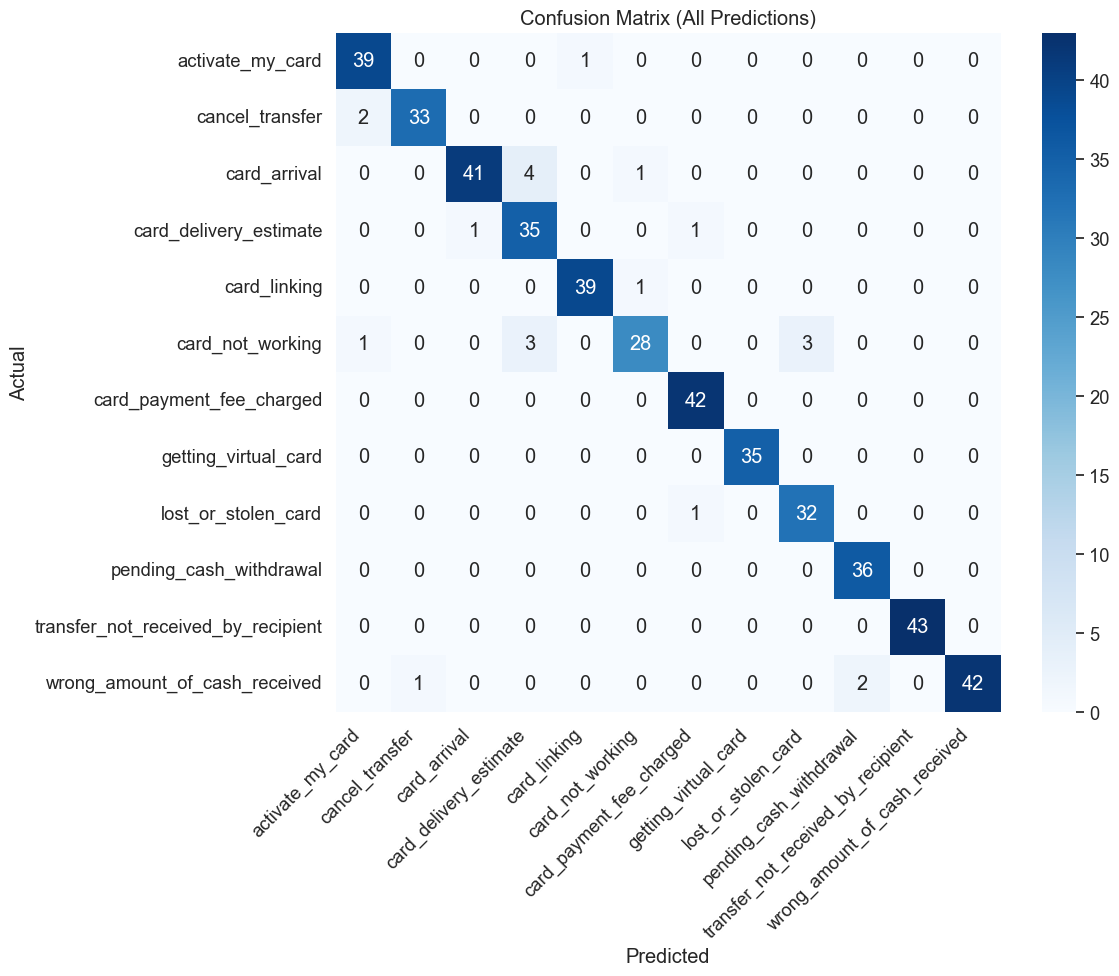


Classification Report (All Predictions):
                                    precision    recall  f1-score   support

                  activate_my_card     0.9286    0.9750    0.9512        40
                   cancel_transfer     0.9706    0.9429    0.9565        35
                      card_arrival     0.9762    0.8913    0.9318        46
            card_delivery_estimate     0.8333    0.9459    0.8861        37
                      card_linking     0.9750    0.9750    0.9750        40
                  card_not_working     0.9333    0.8000    0.8615        35
          card_payment_fee_charged     0.9545    1.0000    0.9767        42
              getting_virtual_card     1.0000    1.0000    1.0000        35
               lost_or_stolen_card     0.9143    0.9697    0.9412        33
           pending_cash_withdrawal     0.9474    1.0000    0.9730        36
transfer_not_received_by_recipient     1.0000    1.0000    1.0000        43
     wrong_amount_of_cash_received     1.0000

In [ ]:
class_names = [
    "activate_my_card", "cancel_transfer", "card_arrival",
    "card_delivery_estimate", "card_linking", "card_not_working",
    "card_payment_fee_charged", "getting_virtual_card",
    "lost_or_stolen_card", "pending_cash_withdrawal",
    "transfer_not_received_by_recipient", "wrong_amount_of_cash_received"
]

def test(model, test_loader, device, confidence_threshold):
    model.eval()
    total_samples = 0
    test_correct = 0
    total_loss = 0.0
    
    all_labels = []
    all_preds = []
    confident_samples = 0

    with torch.no_grad():
        for batch in test_loader:
            inputs, attention_mask, labels = batch
            inputs = inputs.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs_dict = model(inputs, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs_dict.logits, labels)
            total_loss += loss.item()

            probabilities = torch.softmax(outputs_dict.logits, dim=1)
            max_probs, preds = torch.max(probabilities, dim=1)
            
            # Apply confidence threshold
            mask = max_probs >= confidence_threshold
            valid_labels = labels[mask]
            valid_preds = preds[mask]
            
            # Update counters
            test_correct += (valid_preds == valid_labels).sum().item()
            confident_samples += mask.sum().item()
            total_samples += labels.size(0)
            
            # Store for metrics
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calculate metrics
    avg_test_loss = total_loss / len(test_loader)
    confident_acc = test_correct / confident_samples if confident_samples > 0 else 0
    coverage = confident_samples / total_samples

    print(f"\nTest Results (Confidence ≥{confidence_threshold}):")
    print(f"Avg Loss: {avg_test_loss:.4f}")
    print(f"Confident Accuracy: {confident_acc:.4f}")
    print(f"Coverage: {coverage:.2%} ({confident_samples}/{total_samples})")

    # Confusion Matrix (all predictions)
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (All Predictions)')
    plt.tight_layout()
    plt.show()

    # Classification Report (all predictions)
    print("\nClassification Report (All Predictions):")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    return avg_test_loss, confident_acc, coverage

# Run test
test_loss, test_acc, coverage = test(model, test_loader, device, confidence_threshold=0.75)

In [ ]:
torch.save(model.state_dict(), 'banking77.pth')